<a href="https://colab.research.google.com/github/itssofiarce/AA1-TUIA-Petetta-Arce/blob/sofi_main/tp_integrador_aa1_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
path= '/content/drive/MyDrive/weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [7]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [8]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [9]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [10]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [11]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [12]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [13]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [14]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [15]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [16]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow', 'RainfallTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [17]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [18]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [19]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('treat_outliers',OutliersTreater()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [20]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116329, 23), (29083, 23), (116329, 1), (29083, 1))

In [21]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [22]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [23]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.transform(df_test)

# Balanceo de datos

In [24]:
# Modulos para el balanceo
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [25]:
def plot_balance(df):
  ### Balance de datos:
  rain_classes = pd.value_counts(df['RainTomorrow'], sort = True)
  rain_classes.plot(kind = 'bar', rot=0)
  plt.xticks(range(2))
  plt.title("Frecuencia")
  plt.xlabel("RainTomorrow")
  plt.ylabel("Cantidad")
  X_train_resampled=df.drop(['RainTomorrow'], axis=1)
  y_train_resampled=df['RainTomorrow']
  print(X_train_resampled.shape, y_train_resampled.shape)
  plt.show()


In [26]:
# Helper function for plotting ROC -- > https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

Una vez hecho el split entre train y test, verificamos que el dataset esté balanceado.

(19226, 25) (19226,)


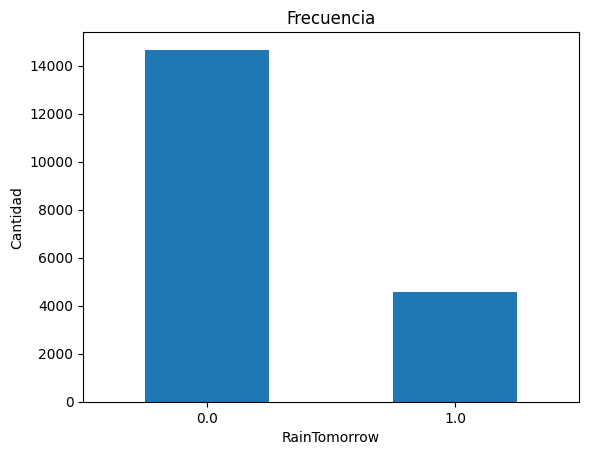

In [27]:
plot_balance(df_train)

En el gráfico de arriba se puede ver como en el dataframe original la cantidad de muestras para los dias de lluvia son mucho menor que la de los días que no llovieron.

De las 10000 muestras en el dataset original con datos de toda Australia, quedaron alrededor de 19000 pertenecientes a la costa este australiana.

Comparamos con AUC que técnica de balanceo de datos es mejor para la regresión logística

In [28]:
# Separación de variables explicativas y variables objetivo
X_train_balance = df_train.drop(['RainTomorrow'], axis=1).copy()
y_train_balance = df_train['RainTomorrow'].copy()

X_test_balance = df_test.drop(['RainTomorrow'], axis=1).copy()
y_test_balance = df_test['RainTomorrow'].copy()

In [29]:
X_train_balance.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'costa_este', 'WindGustDir_sin',
       'WindGustDir_cos', 'WindDir9am_sin', 'WindDir9am_cos', 'WindDir3pm_sin',
       'WindDir3pm_cos', 'RainToday', 'RainfallTomorrow'],
      dtype='object')

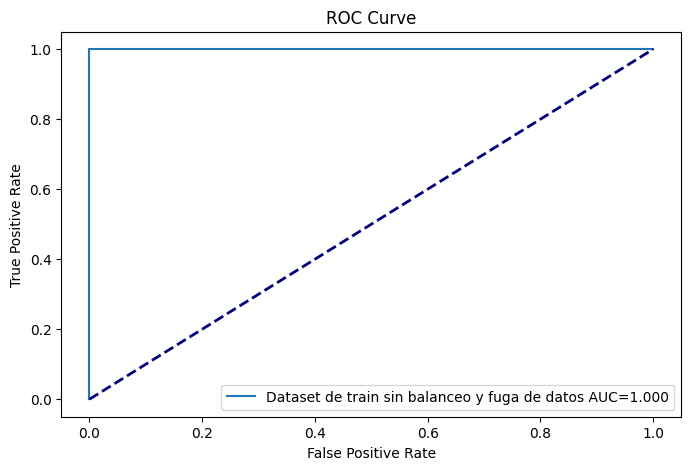

In [30]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_balance, y_train_balance, X_test_balance, y_test_balance, 'Dataset de train sin balanceo y fuga de datos')

Se puede ver como el modelo ajusta perfectamente cuando se usa el dataset completo incluso sin balancear. La razón de esto es que el modelo tiene fuga de datos porque en el Dataset existe 'RainfallTomorrow'. Por eso para elegir el mejor método de balanceo de datos para la regresión logística vamos a droppear de nuestro Dataset ya balanceado a 'RainfallTomorrow'.

#### - Balanceo con Oversampling

In [31]:
ros = RandomOverSampler(random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train_balance, y_train_balance)

In [32]:
df_ros = pd.DataFrame(X_train_ros, columns=X_train_balance.columns)
df_ros['RainTomorrow'] = y_train_ros

(29328, 25) (29328,)


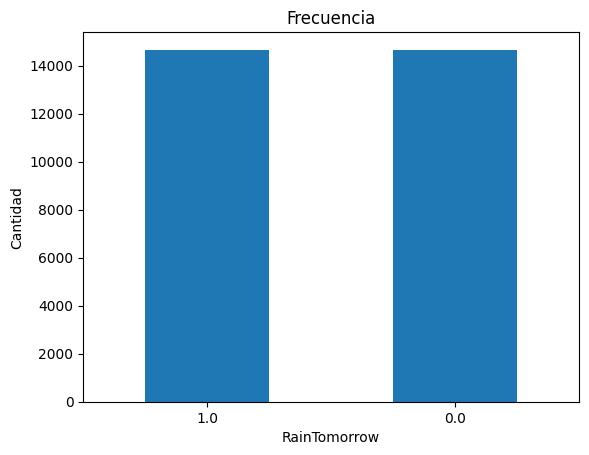

In [33]:
plot_balance(df_ros)

In [34]:
df_ros.shape[0]

29328

Con el sobremuestreo, la clase minoritaria ahora tiene igual cantidad de muestras que la clase mayoritaria. Teniendo como resultado un dataframe de testeo de 29328 muestras

#### - Balanceo con Undersampling

In [35]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_balance, y_train_balance)

In [36]:
df_rus = pd.DataFrame(X_train_rus, columns=X_train_balance.columns)
df_rus['RainTomorrow'] = y_train_rus

(9124, 25) (9124,)


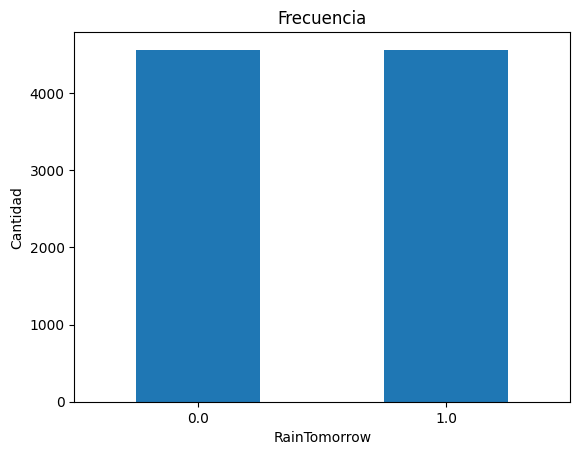

In [37]:
plot_balance(df_rus)

Con el submuestreo, la clase mayoritaria ahora tiene igual cantidad de muestras que la clase minoritaria. Teniendo como resultado un data frame de testeo de alrededor de 9124 muestras

#### - Balanceo con SMOTE


In [38]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_balance, y_train_balance)

In [39]:
df_SMOTE = pd.DataFrame(X_train_smote, columns=X_train_balance.columns)
df_SMOTE['RainTomorrow'] = y_train_smote

(29328, 25) (29328,)


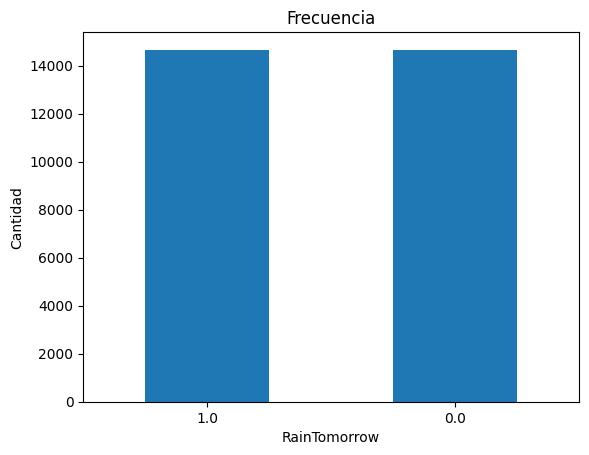

In [40]:
plot_balance(df_SMOTE)

Con SMOTE obtuvimos las mismas cantidad de registros que con la técnica de oversampling (29328). Sin embargo, a diferencia del *random oversampling*, SMOTE aumenta tambien la variabilidad del dataset.

#### - Balanceo con SMOTE(oversampling)-TOMEK(undersampling)

Además, investigamos otras maneras de balancear el DataSet y nos encontramos con SMOTE-TOMEK. Esta técnica combina el sobresampleo con SMOTE con el subsampleo con TOMEK Link que toma dos puntos cercanos de diferentes clases y por cada par se borran aquellos que pertenezcan a la clase mayoritoria, de esa forma el límite de decisión se vuelve mas claro.

  Fuente: https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a

In [41]:
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_balance, y_train_balance)

In [42]:
df_smotetomek = pd.DataFrame(X_train_smotetomek, columns=X_train_balance.columns)
df_smotetomek['RainTomorrow'] = y_train_smotetomek

(29304, 25) (29304,)


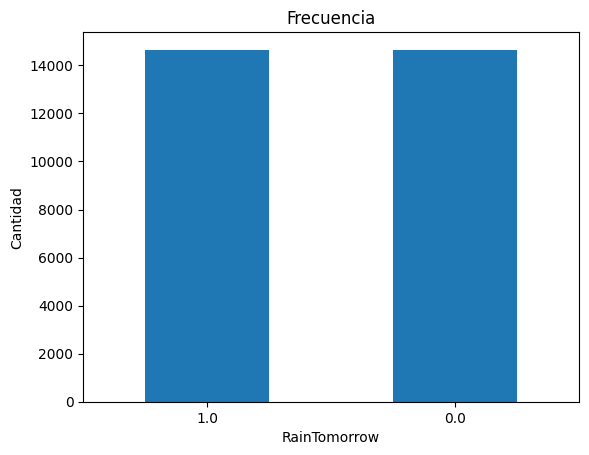

In [43]:
plot_balance(df_smotetomek)

In [44]:
# VARIABILIDAD DE LOS DATASETS BALANCEADOS CON: Oversampling, SMOTE, SMOTE-Tomek
std_combined = pd.DataFrame([df_ros.describe().loc['std'], df_SMOTE.describe().loc['std'], df_smotetomek.describe().loc['std'], df_test.describe().loc['std']]).T
std_combined.columns = ['Oversampling', 'SMOTE', 'SMOTE-Tomek', 'Original']
std_combined

,Oversampling,SMOTE,SMOTE-Tomek,Original
MinTemp,0.987512,0.963607,0.962966,1.000105
MaxTemp,0.991248,0.974581,0.974044,1.000105
Rainfall,1.090803,1.089066,1.088924,1.000105
Evaporation,0.991733,0.965268,0.964658,1.000105
Sunshine,1.026118,1.009306,1.009358,1.000105
WindGustSpeed,1.048195,1.014671,1.014715,1.000105
WindSpeed9am,1.027280,0.991852,0.992015,1.000105
WindSpeed3pm,1.028928,0.989803,0.989392,1.000105
Humidity9am,0.987642,0.967738,0.967465,1.000105
Humidity3pm,1.062193,1.040295,1.040211,1.000105


A pesar de estar balanceados con diferentes técnicas el DF_ros(sobresampleo),  DF_SMOTE(SMOTE), SMOTETomek(SMOTE-Tomek) tienen una variabilidad muy parecida por lo que es de esperar que su performance sea muy parecida.

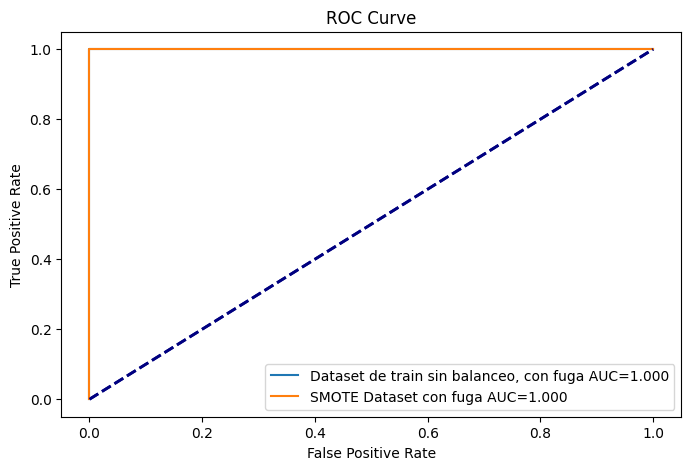

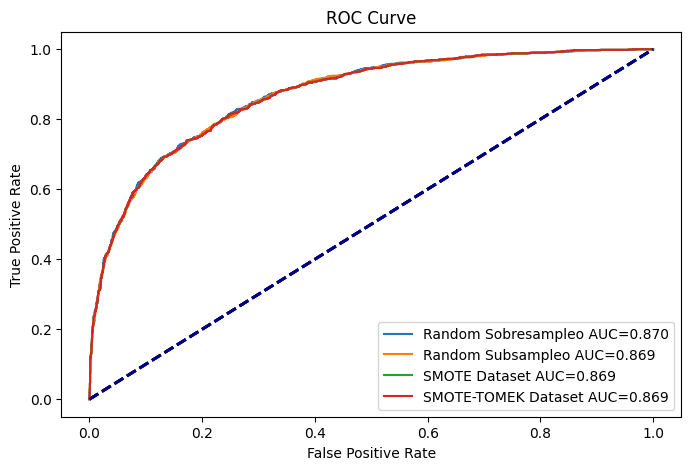

In [45]:
# Plot all ROC into one graph , y_train_balance
fig,ax = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax, X_train_balance, y_train_balance, X_test_balance, y_test_balance, 'Dataset de train sin balanceo, con fuga')
plot_roc(ax, X_train_smote, y_train_smote, X_test_balance, y_test_balance, 'SMOTE Dataset con fuga')

fig,ax1 = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax1, X_train_ros.drop(['RainfallTomorrow'], axis=1), y_train_ros, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'Random Sobresampleo')
plot_roc(ax1, X_train_rus.drop(['RainfallTomorrow'], axis=1), y_train_rus, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'Random Subsampleo')
plot_roc(ax1, X_train_smote.drop(['RainfallTomorrow'], axis=1), y_train_smote, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'SMOTE Dataset')
plot_roc(ax1, X_train_smotetomek.drop(['RainfallTomorrow'], axis=1), y_train_smotetomek, X_test_balance.drop(['RainfallTomorrow'], axis=1), y_test_balance, 'SMOTE-TOMEK Dataset')

Un dataset no balanceado pero con fuga de datos hace overfitting, al igual que un dataset balanceado (en el gráfico optamos por SMOTE) con fuga.

Podemos concluir que para este modelo (regresión logística) teniendo en cuenta todas las features, las diferentes técnicas de resampleo tienen valores muy parecidos y cercanos a uno, lo que siginifica que el TPR (ratio de verdaderos positivos) es mas alto que el FPR (ratio de falsos positivos, es decir, predice dias de no lluvia como lluvia)  

# Evaluación - Con todas las features


### Regresión Logistica

In [46]:
def plot_matrix_confusion(y_test, y_pred):
  # Calcular la matriz de confusión
  confusion_mat = confusion_matrix(y_test, y_pred)

  # Crear una figura y un eje para la matriz de confusión
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='blue', cbar=True)

  # Añadir etiquetas a los ejes y al gráfico
  plt.xlabel('Predicción')
  plt.ylabel('Verdaderos')
  plt.title('Matriz de Confusión')
  plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.show()

In [47]:
def train_test_with_balanced_df(df_train, df_test, model, title=None):
  """ Entrena, muestra métricas y plotea la curva AUC """
  X_train = df_train.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
  y_train = df_train['RainTomorrow'].copy()

  X_test = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
  y_test = df_test['RainTomorrow'].copy()

  my_model = model(random_state=42)
  my_model.fit(X_train, y_train)
  y_pred = my_model.predict(X_test)


  print(f"Resultados con: {model.__name__}\n")
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  print(f"\n\nMatriz de confusión para: {model.__name__}")
  plot_matrix_confusion(y_test, y_pred)

  fig,ax = plt.subplots(1,1,figsize=(8,5))
  y_test_pred = my_model.predict_proba(X_test)[:,1]
  fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)

  # Posicion del indice del umbral 0.5
  thresh_index = np.abs(thresh - 0.5).argmin()
  # Posicion del indice del umbral con valores mas cercanos a (0,1) para TPR y FPR
  optimal_index = ((1 - tpr**2) + fpr**2).argmin()


  auc = metrics.roc_auc_score(y_test, y_test_pred)
  ax.plot(fpr,tpr,label=f"Logistic Regression AUC={auc:.3f}")
  ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

  ax.set_title(f'{title}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend(loc=0)

  print(f"\n\nUmbrales:")
  print(f"Actual: {thresh[thresh_index]}")
  print(f"Optimo: {thresh[optimal_index]}")

  print(f"\n\nPuntaje para training vs test")
  print(f"Training: {my_model.score(X_train, y_train)}")
  print(f"Test: {my_model.score(X_test, y_test)}")

Resultados con: LogisticRegression

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      3651
         1.0       0.53      0.77      0.62      1098

    accuracy                           0.79      4749
   macro avg       0.72      0.78      0.74      4749
weighted avg       0.83      0.79      0.80      4749

[[2893  758]
 [ 256  842]]


Matriz de confusión para: LogisticRegression


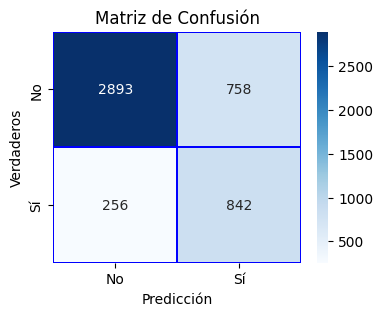



Umbrales:
Actual: 0.49987910508372824
Optimo: 0.29548354292085544


Puntaje para training vs test
Training: 0.7881546644844517
Test: 0.786481364497789


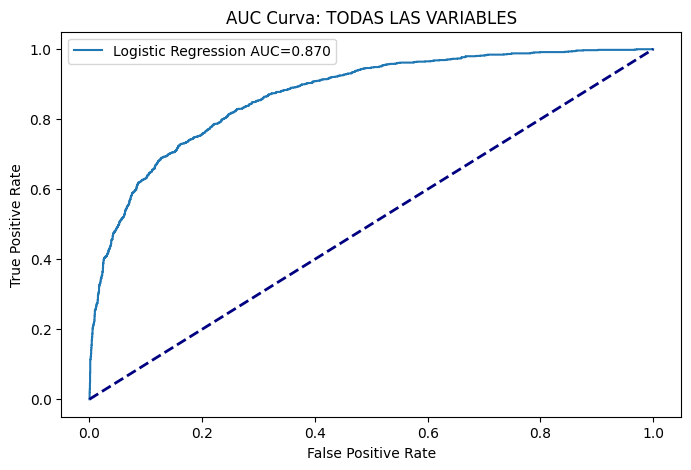

In [48]:
train_test_with_balanced_df(df_ros, df_test, LogisticRegression, "AUC Curva: TODAS LAS VARIABLES")

Hay overfitting porque mi modelo funciona un poco mejor para mi conjunto de train que de test. Por eso vamos a probar de simplificar el modelo, eliminando caracteristicas con poca correlacion

In [49]:
df_ros_selected_feats=df_ros.drop(['Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm','costa_este','WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin','WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos'], axis=1, inplace=False)

In [50]:
df_test_selected_feats=df_test.drop(['Sunshine','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm','costa_este','WindGustDir_sin', 'WindGustDir_cos', 'WindDir9am_sin','WindDir9am_cos', 'WindDir3pm_sin', 'WindDir3pm_cos'], axis=1, inplace=False)

Resultados con: LogisticRegression

              precision    recall  f1-score   support

         0.0       0.91      0.77      0.83      3651
         1.0       0.49      0.74      0.59      1098

    accuracy                           0.76      4749
   macro avg       0.70      0.76      0.71      4749
weighted avg       0.81      0.76      0.78      4749

[[2816  835]
 [ 283  815]]


Matriz de confusión para: LogisticRegression


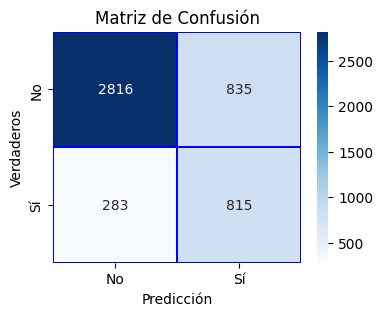



Umbrales:
Actual: 0.4998019520038621
Optimo: 0.34593985298825425


Puntaje para training vs test
Training: 0.769537643207856
Test: 0.764582017266793


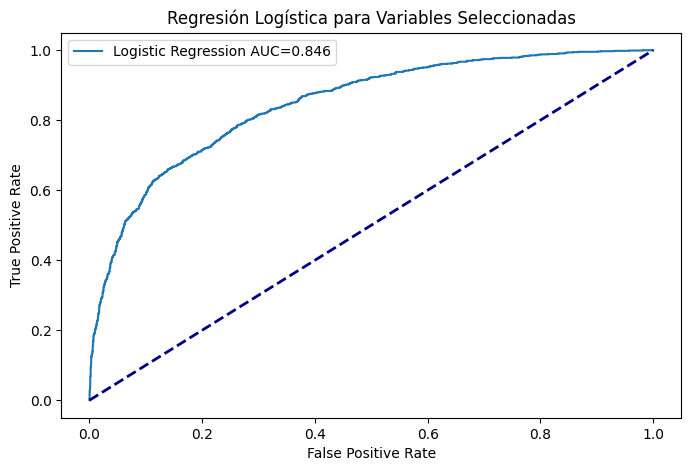

In [51]:
train_test_with_balanced_df(df_ros_selected_feats, df_test_selected_feats, LogisticRegression, "Regresión Logística para Variables Seleccionadas")

Sigue habiendo overfitting, por lo que vamos a simplificar el modelo en dos variables.

In [52]:
feat_cols = ['Humidity9am','Humidity3pm']
X_2D = df_ros[feat_cols]
y_2D = df_ros['RainTomorrow']

In [53]:
logreg_2D = LogisticRegression()
X_train_2D, X_test_2D, y_train_2D, y_test_2D = train_test_split(X_2D, y_2D, test_size=0.2, random_state=42)

In [54]:
# Modelos con SOLO DOS de sus features
logreg_2D.fit(X_train_2D, y_train_2D)

# Realizar predicciones en el conjunto de prueba
y_pred_2D = logreg_2D.predict(X_test_2D)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


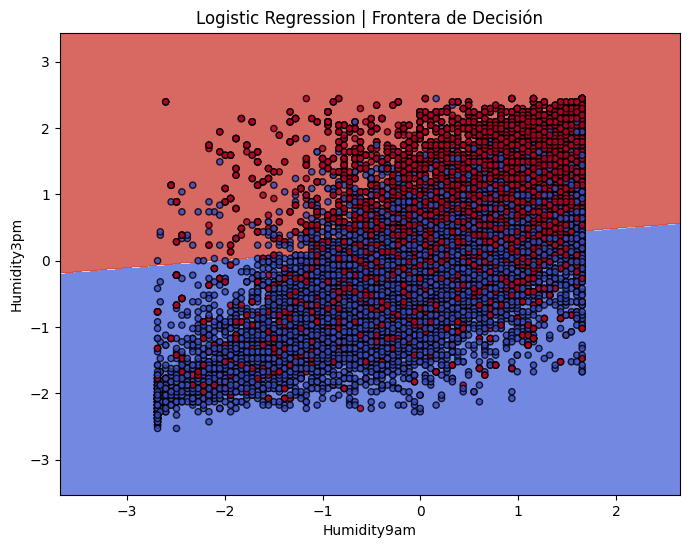

In [55]:
# Assuming X_train_2D_values is a NumPy array with two columns
X_train_2D_values = X_train_2D.values

# Define the mesh grid for plotting the decision boundary
x_min, x_max = X_train_2D_values[:, 0].min() - 1, X_train_2D_values[:, 0].max() + 1
y_min, y_max = X_train_2D_values[:, 1].min() - 1, X_train_2D_values[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the class for each point in the mesh grid
Z = logreg_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2D_values[:, 0], X_train_2D_values[:, 1], c=y_train_2D, alpha=0.8,
            cmap=plt.cm.coolwarm, edgecolors='k', s=20)
plt.xlabel('Humidity9am')
plt.ylabel('Humidity3pm')
plt.title('Logistic Regression | Frontera de Decisión')
plt.show()


Se observa que los valores predecidos no tienen una muy buena distribución para evaluar la región logistica por lo que probaremos seleccionando otras variables con mejor distribución para la regresión.

In [56]:
feat_cols = ['MaxTemp','MinTemp']
X_2D_pt2 = df_ros[feat_cols]
y_2D_pt2 = df_ros['RainTomorrow']

In [57]:
X_train_2D_pt2, X_test_2D_pt2, y_train_2D_pt2, y_test_2D_pt2 = train_test_split(X_2D_pt2, y_2D_pt2, test_size=0.2, random_state=42)

In [58]:
# Modelos con SOLO DOS de sus features
logreg_2D.fit(X_train_2D_pt2, y_train_2D_pt2)

# Realizar predicciones en el conjunto de prueba
y_pred_2D = logreg_2D.predict(X_test_2D_pt2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


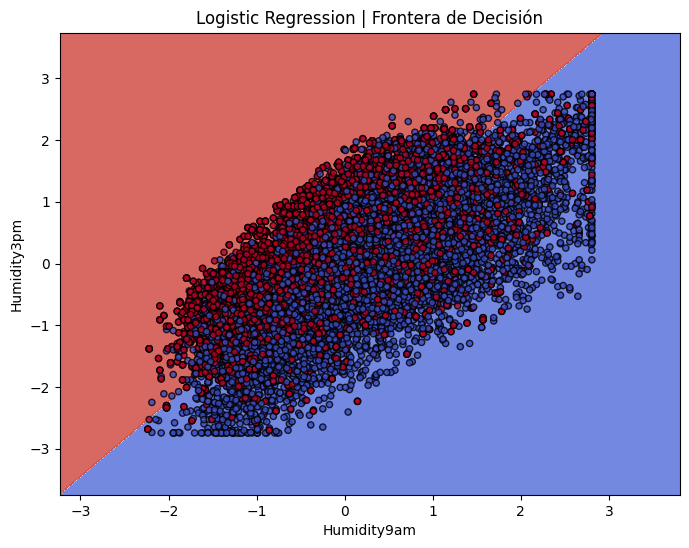

In [59]:
# Assuming X_train_2D_values is a NumPy array with two columns
X_train_2D_values = X_train_2D_pt2.values

# Define the mesh grid for plotting the decision boundary
x_min, x_max = X_train_2D_values[:, 0].min() - 1, X_train_2D_values[:, 0].max() + 1
y_min, y_max = X_train_2D_values[:, 1].min() - 1, X_train_2D_values[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict the class for each point in the mesh grid
Z = logreg_2D.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary and data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2D_values[:, 0], X_train_2D_values[:, 1], c=y_train_2D, alpha=0.8,
            cmap=plt.cm.coolwarm, edgecolors='k', s=20)
plt.xlabel('Humidity9am')
plt.ylabel('Humidity3pm')
plt.title('Logistic Regression | Frontera de Decisión')
plt.show()


# Con una variable

# Modelo Base


In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier
from sklearn.dummy import DummyClassifier, DummyRegressor


df_base=preprocessor.fit_transform(df)
X=df_base.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y=df_base['RainTomorrow']
y_reg=df_base['RainfallTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=777)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg,test_size=0.3, stratify=y, random_state=777)

#### Clasificación

El modelo base "Basado En La Mayoría" para clasificación

In [61]:
# Crear un clasificador de la mayoría
dummy_clf = DummyClassifier(strategy="most_frequent")

# Entreno, aunque no es necesario porque no aprende nada
dummy_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = dummy_clf.predict(X_test)

# Score
dummy_clf.score(X_test, y_test)

# Metricas
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[5495    0]
 [1698    0]]
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.87      5495
         1.0       0.00      0.00      0.00      1698

    accuracy                           0.76      7193
   macro avg       0.38      0.50      0.43      7193
weighted avg       0.58      0.76      0.66      7193



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


es una advertencia emitida por scikit-learn cuando la precisión y el F-score son indefinidos (es decir, no se pueden calcular) para algunas clases debido a que no se realizaron predicciones para esas clases en el conjunto de prueba.

Este problema suele ocurrir cuando tienes clases raras o desbalanceadas en tu conjunto de datos y el modelo no puede predecir esas clases en absoluto en el conjunto de prueba. Por lo tanto, las métricas de precisión y F-score para esas clases se establecen en 0.0.

In [62]:
df_base.value_counts("RainTomorrow", normalize=True)

RainTomorrow
0.0    0.763921
1.0    0.236079
Name: proportion, dtype: float64

La presición obtenida es equivalente a predecir siempre que no lloverá, habría asertado un 76% de los casos según nuestro data set.

El cual podemos verificarlo rápidamente contando la cantidad de cada valor de la variable a predecir.  Nuestro modelo dirá todas las predicciones que NO lloverá pero éste tendra una eficiencia del 76%.


#### Regresión

In [63]:
y_reg.std()

6.523620449707548

El modelo base predice segun la media

In [64]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(X_train_reg, y_train_reg)

y_pred = dummy_regr.predict(X_test_reg)

# Metricas
mse = mean_squared_error(y_test_reg, y_pred)

r2 = r2_score(y_test_reg, y_pred)

print(f"Mean squared error: {mse}")
print(f"R-squared score: {r2}")

Mean squared error: 40.98008127917674
R-squared score: -4.1095204644792105e-05


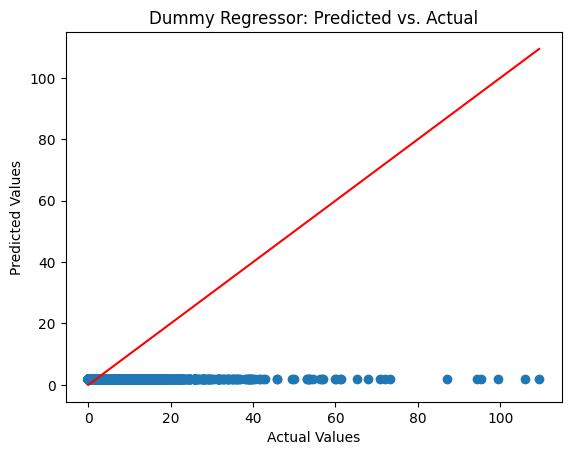

In [65]:
# Plot the predicted values against the actual values
plt.scatter(y_test_reg, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Dummy Regressor: Predicted vs. Actual")
# Add a diagonal line to show where the predicted values match the actual values
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color="red")

Es muy malo ya que predice alrededor de 40 ml mas para cada punto de salida.Debemos estudiar la linealidad entre dos variables para poder crear un modelo base mejor

#Optimizacion de parametros

In [66]:
from sklearn.model_selection import GridSearchCV

### Analisis de los HP

In [67]:
### Para cada hiperparámetro se chequean las métricas de Precisión y Recall.

scores = ["precision", "recall"]

In [68]:
def print_dataframe(filtered_cv_results):
    ### Un print bonito de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

In [69]:
def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.7, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [70]:
from sklearn.metrics import classification_report

# Spliteo mi dataset en train-test
X_train_gs = df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1)
y_train_gs = df_test['RainTomorrow']

In [71]:
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train_gs, y_train_gs)

All grid-search results:
precision: 0.724 (±0.038), recall: 0.515 (±0.059), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.724 (±0.038), recall: 0.515 (±0.059), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.531 (±0.018), recall: 0.771 (±0.017), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.531 (±0.018), recall: 0.771 (±0.017), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.728 (±0.035), recall: 0.529 (±0.052), for {'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.728 (±0.035), recall: 0.529 (±0.052), for {'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.535 (±0.016), recall: 0.768 (±0.014), for {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.535 (±0.016), recall: 0.768 (±0.014), for {'C': 1, 'cl

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500], 'solver': ['newton-cg']}],
             refit=<function refit_strategy at 0x7d010f77c550>,
             scoring=['precision', 'recall'])

In [72]:
grid_search.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}

In [73]:
y_pred = grid_search.predict(df_test.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1))
print(classification_report(df_test['RainTomorrow'], y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.91      3651
         1.0       0.74      0.53      0.62      1098

    accuracy                           0.85      4749
   macro avg       0.80      0.74      0.76      4749
weighted avg       0.84      0.85      0.84      4749



No hay mejoras en cuanto a la performance del modelo sin los hiperparametros optimizados :(
  

pendiente: justificar el uso de grid search

# Explicabilidad - Clasificación

In [89]:
!pip install shap;
import shap
import seaborn as sns

In [75]:
def boxplots(X,y, columns):
  data = pd.concat([pd.DataFrame(y, columns=['target']), pd.DataFrame(X, columns=columns)], axis=1)

  num_features = X.shape[1]
  num_rows = num_features // 3 + 1

  fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
  fig.subplots_adjust(hspace=0.5)

  # Se recorre cada feature para generar su diagrama de caja respecto de la salida
  for i, feature in enumerate(data.columns[1:]):
      row = i // 3
      col = i % 3
      sns.boxplot(x='target', y=feature, data=data, ax=axes[row, col])
      axes[row, col].set_title(f'Diagrama de caja de {feature}')
      axes[row, col].set_xlabel('Target')
      axes[row, col].set_ylabel(feature)

  # Eliminar subplots vacíos si es necesario
  if num_features % 3 != 0:
      for i in range(num_features % 3, 3):
          fig.delaxes(axes[num_rows - 1, i])

  plt.show()


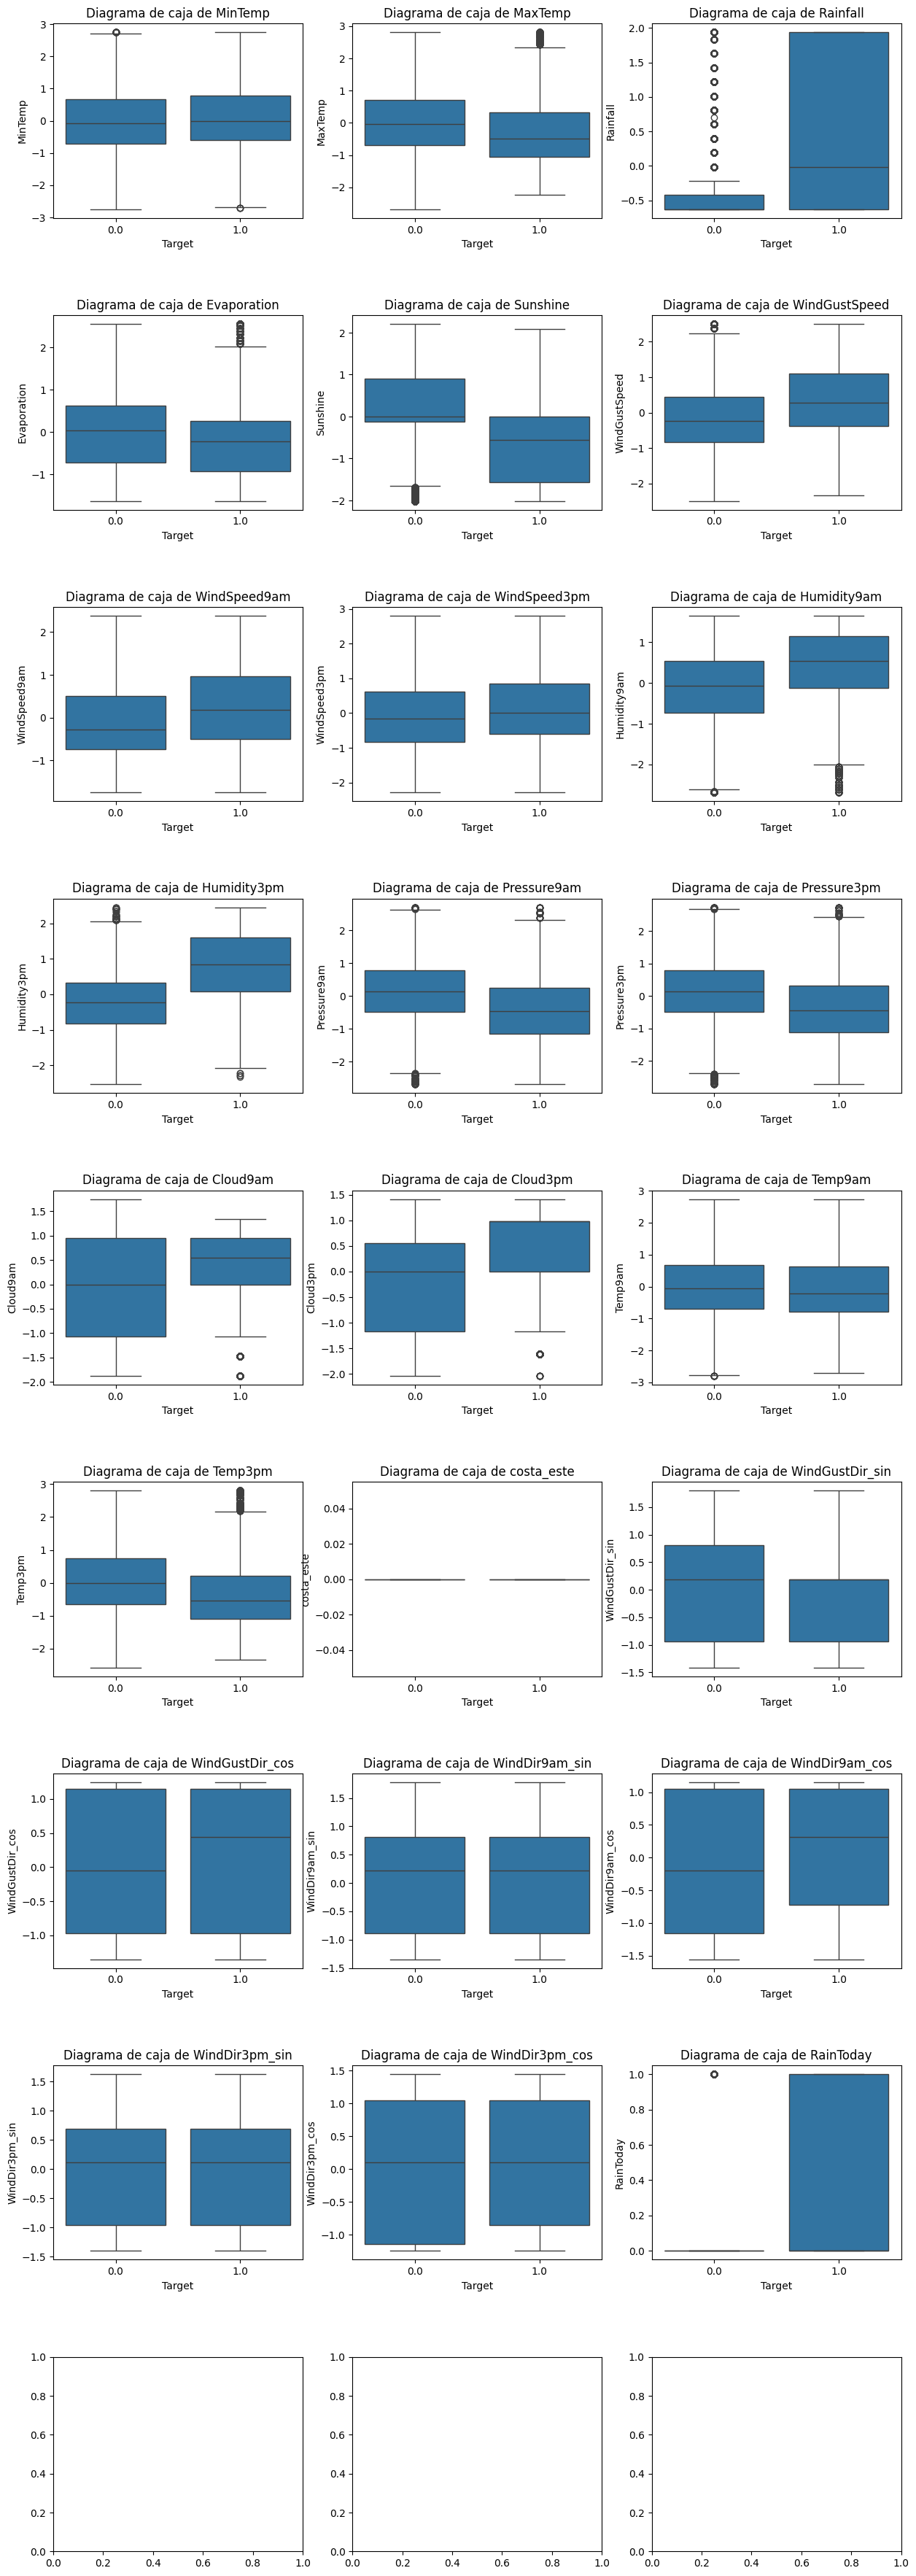

In [82]:
feature_names=df_ros.drop(['RainTomorrow', 'RainfallTomorrow'],axis=1).columns.values
boxplots(df_ros.drop(['RainTomorrow', 'RainfallTomorrow'],axis=1), df_ros['RainTomorrow'].values.reshape(-1,1), feature_names)

In [85]:
model = LogisticRegression()

model.fit(df_ros.drop(['RainTomorrow', 'RainfallTomorrow'],axis=1), df_ros['RainTomorrow'])

LogisticRegression()

In [86]:
y_pred = model.predict(df_test.drop(['RainTomorrow', 'RainfallTomorrow'],axis=1))
y_ajuste_train = model.predict(df_ros.drop(['RainTomorrow', 'RainfallTomorrow'],axis=1))

print('Métricas en el entrenamiento')
print(classification_report(df_ros['RainTomorrow'], y_ajuste_train))
print(confusion_matrix(df_ros['RainTomorrow'], y_ajuste_train))

print('Métricas en el conjunto de prueba')
print(classification_report(df_test['RainTomorrow'], y_pred))
print(confusion_matrix(df_test['RainTomorrow'], y_pred))

Métricas en el entrenamiento
              precision    recall  f1-score   support

         0.0       0.78      0.80      0.79     14664
         1.0       0.79      0.78      0.79     14664

    accuracy                           0.79     29328
   macro avg       0.79      0.79      0.79     29328
weighted avg       0.79      0.79      0.79     29328

[[11705  2959]
 [ 3254 11410]]
Métricas en el conjunto de prueba
              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85      3651
         1.0       0.53      0.77      0.62      1098

    accuracy                           0.79      4749
   macro avg       0.72      0.78      0.74      4749
weighted avg       0.83      0.79      0.80      4749

[[2893  758]
 [ 256  842]]


In [88]:
df_coeficientes=pd.DataFrame(model.coef_.T, index=feature_names)
df_coeficientes

,0
MinTemp,-0.178076
MaxTemp,-0.003655
Rainfall,0.407477
Evaporation,-0.000397
Sunshine,-0.459063
WindGustSpeed,0.725418
WindSpeed9am,-0.072832
WindSpeed3pm,-0.169768
Humidity9am,0.045469
Humidity3pm,1.117203


In [103]:
model = LogisticRegression(random_state=42)
model.fit(df_ros.drop(['RainfallTomorrow', 'RainTomorrow'],axis=1), df_ros['RainTomorrow'])
y_test_pred = model.predict(df_ros.drop(['RainfallTomorrow', 'RainTomorrow'],axis=1))

In [104]:
y_test_pred

array([1., 1., 1., ..., 1., 1., 1.])

In [105]:
df_ros['RainTomorrow']

0        1.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
29323    1.0
29324    1.0
29325    1.0
29326    1.0
29327    1.0
Name: RainTomorrow, Length: 29328, dtype: float64

ValueError: x and y must be the same size

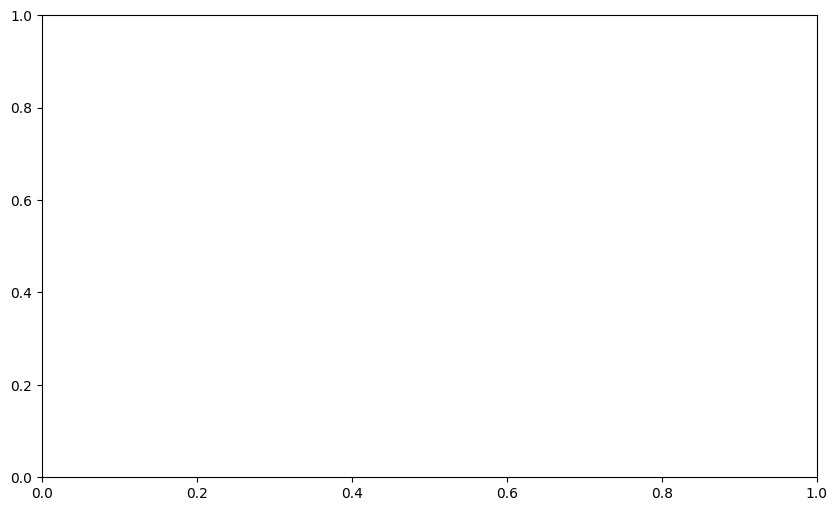

In [106]:
plt.figure(figsize=(10, 6))
plt.scatter(df_ros['RainTomorrow'], y_pred)

### A nivel local


### A nivel global


## Explicabilidad - Clasificación

### A nivel local


### A nivel global